In [11]:
from pyuvdata import UVData
import numpy as np
from matplotlib import pyplot as plt
import os
import inspect
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import h5py
import hdf5plugin
from hera_commissioning_tools import utils
from djs_fhd_pipeline import plots
import scipy

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
dirpath = os.path.dirname(os.path.realpath(nb_name))
currfile = f'{dirpath}/{nb_name}'
githash = utils.get_git_revision_hash(dirpath)

In [8]:
fname = '/lustre/aoc/projects/hera/dstorer/Projects/updatedHeraOnFHD/2459855/uvfitsFiles/medRes_ISO_perSetPhasing/zen.2459855.622379533_mid_10obs_10.uvfits'
uv = UVData()
uv.read(fname)

In [71]:
fullants = '/lustre/aoc/projects/hera/dstorer/Projects/updatedHeraOnFHD/2459855/uvfitsFiles/ISO_perSetPhasing_medResFlaggingOnly/zen.2459855.610076241_mid_10obs_4.uvfits'
uvfull = UVData()
uvfull.read(fullants)

In [133]:
def plotBlLengthHists(uv,use_ants=[],freq=170,bl_cut=25,nbins=10,savefig=False,outfig='',write_params=True,
                     title=''):
    """
    Plots a histogram of baseline lengths, and shows where a particular baseline cut or cuts is.
    
    Parameters:
    ----------
    uv: UVData
        UVData object to use for getting antenna set and baseline length information.
    use_ants: List
        Set of antennas to select on.
    freq: Int
        Frequency in MHz or HZ to calculate baseline cut at.
    bl_cut: Int or List
        Baseline cut or list of baseline cuts to make histograms for - should be in units of n lambda.
    nbins: Int
        Number of bins to use in histogram.
    savefig: Boolean
    outfig: String
    write_params: Boolean
    """
    args = locals()
    if len(use_ants)>0:
        uv.select(use_ants=use_ants)
    baseline_groups, vec_bin_centers, lengths = uv.get_redundancies(
        use_antpos=False, include_autos=False
    )
    antpairs, lengths = plots.unpackBlLengths(uv, baseline_groups,lengths)
    if type(bl_cut)==int:
        ncuts=1
        bl_cut = [bl_cut]
    else:
        ncuts = len(bl_cut)
    if freq < 1000:
        freq = freq*1e6
    wl = scipy.constants.speed_of_light/freq
    bl_cut_m=np.asarray(bl_cut)*wl
    for i,cut in enumerate(bl_cut):
        print(f'Baseline cut of {cut} lambda is at {np.round(bl_cut_m[i],1)} meters at {int(freq*1e-6)}MHz')
    
    fig = plt.figure(figsize=(6,4))
    plt.hist(lengths,bins=nbins,histtype='step')
    plt.xlabel('Baseline Length(m)')
    plt.ylabel('Count')
    plt.xlim((0,max(lengths)+20))
    colors=['black','red','cyan','green','gold']
    for i,cut in enumerate(bl_cut_m):
        plt.axvline(cut,linestyle='--',label=f'{np.round(bl_cut[i],1)} lambda cut',color=colors[i])
    plt.legend()
    plt.title(title)
    if savefig:
        plt.savefig(outfig)
        if write_params:
            curr_func = inspect.stack()[0][3]
            utils.write_params_to_text(outfig,args,curr_func,curr_file,githash)

Baseline cut of 25 lambda is at 50.0 meters at 150MHz
Baseline cut of 40 lambda is at 79.9 meters at 150MHz
Baseline cut of 25 lambda is at 50.0 meters at 150MHz
Baseline cut of 40 lambda is at 79.9 meters at 150MHz


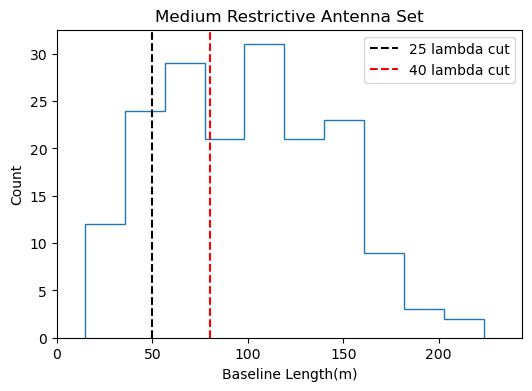

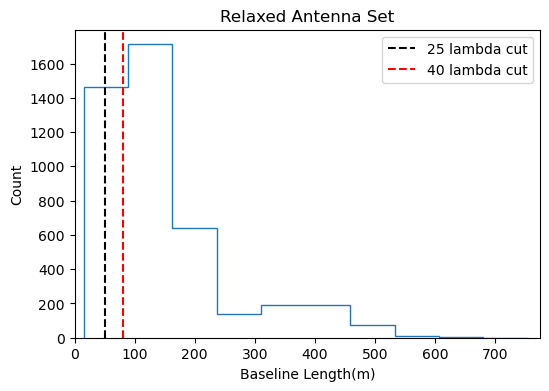

In [134]:
plotBlLengthHists(uv,bl_cut=[25,40],freq=150,title='Medium Restrictive Antenna Set')
plotBlLengthHists(uvfull,bl_cut=[25,40],freq=150,title='Relaxed Antenna Set')

In [108]:
def plotBlLengthHists_perAnt(uv,use_ants=[],freq=170,bl_cut=25,nbins=10,savefig=False,outfig='',
                             write_params=True,suptitle=''):
    """
    Plots a histogram of the number of baselines each antenna has that survive a certain baseline cut or cuts.
    
    Parameters:
    -----------
    uv: UVData
        UVData object to use for getting antenna set and baseline length information
    use_ants: List
        Set of antennas to select on.
    freq: Int
        Frequency in MHz or HZ to calculate baseline cut at
    bl_cut: Int or List
        Baseline cut or list of baseline cuts to make histograms for - should be in units of n lambda.
    nbins: Int
        Number of bins to use in histogram
    savefig: Boolean
    Outfig: String
    write_params: Boolean
    suptitle: String
    """
    args = locals()
    if len(use_ants)>0:
        uv.select(use_ants=use_ants)
    baseline_groups, vec_bin_centers, lengths = uv.get_redundancies(
        use_antpos=False, include_autos=False
    )
    nants = len(uv.get_ants())
    if type(bl_cut)==int:
        ncuts=1
    else:
        ncuts=len(bl_cut)
    counts = np.zeros((nants,ncuts))
    antpairs, lengths = plots.unpackBlLengths(uv, baseline_groups,lengths)
    if freq < 1000:
        freq = freq*1e6
    wl = scipy.constants.speed_of_light/freq
    bl_cut_m=np.asarray(bl_cut)*wl
    print(f'Baseline cut of {bl_cut} lambda is {np.round(bl_cut_m,1)} meters at {int(freq*1e-6)}MHz')
    for i,ant in enumerate(uv.get_ants()):
        bls = [(bl[0],bl[1]) for bl in antpairs if (bl[0]==ant or bl[1]==ant)]
        lens = np.asarray(plots.getBaselineLength(uv,bls))
        if ncuts==1:
            c = np.count_nonzero(lens>=bl_cut_m)
            counts[i] = c
        else:
            for j,cut in enumerate(bl_cut_m):
                c = np.count_nonzero(lens>=bl_cut_m[j])
                counts[i,j] = c

    if ncuts == 1:
        fig = plt.figure(figsize=(8,6))
        plt.hist(counts,bins=nbins,histtype='step')
        plt.xlabel('# Baselines above cut per antenna')
        plt.ylabel('Count')
        plt.xlim((0,max(counts)+2))
    else:
        ymax = 0
        for n in range(ncuts):
            hist, edges = np.histogram(counts[:,n],bins=nbins)
            if np.max(hist) > ymax:
                ymax = np.max(hist)
        ymax = np.round(ymax*1.1,0)
        fig, ax = plt.subplots(1,ncuts,figsize=(10,4))
        for i,cut in enumerate(bl_cut_m):
            ax[i].hist(counts[:,i],bins=nbins,histtype='step')
#             ax[i].plot(hist)
            ax[i].set_xlabel('# Baselines above cut per antenna')
            ax[i].set_ylabel('Count')
            ax[i].set_xlim((0,np.max(counts)+2))
            ax[i].set_title(f'{np.round(cut,1)}m/{bl_cut[i]}lambda baseline cut')
            ax[i].set_ylim((0,ymax))
    plt.suptitle(suptitle)
    plt.tight_layout()
#     plt.axvline(bl_cut_m,linestyle='--',color='k')
    if savefig:
        plt.savefig(outfig)
        if write_params:
            curr_func = inspect.stack()[0][3]
            utils.write_params_to_text(outfig,args,curr_func,curr_file,githash)

Baseline cut of [25, 40] lambda is [50.  79.9] meters at 150MHz
Baseline cut of [25, 40] lambda is [50.  79.9] meters at 150MHz


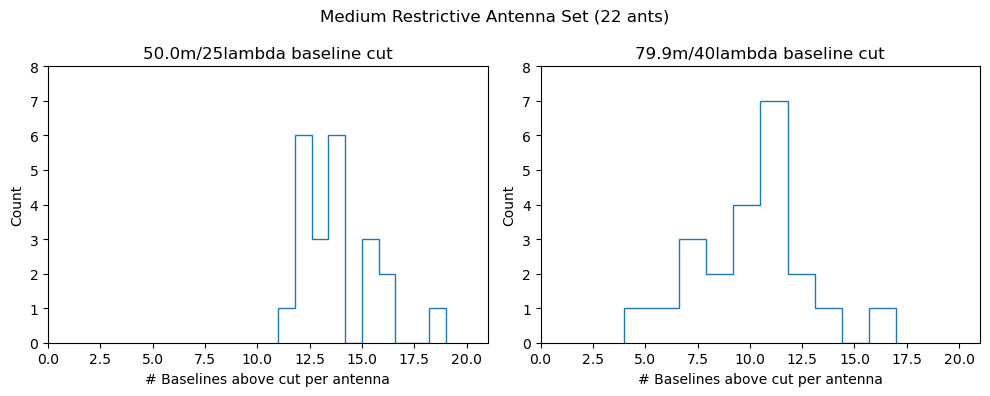

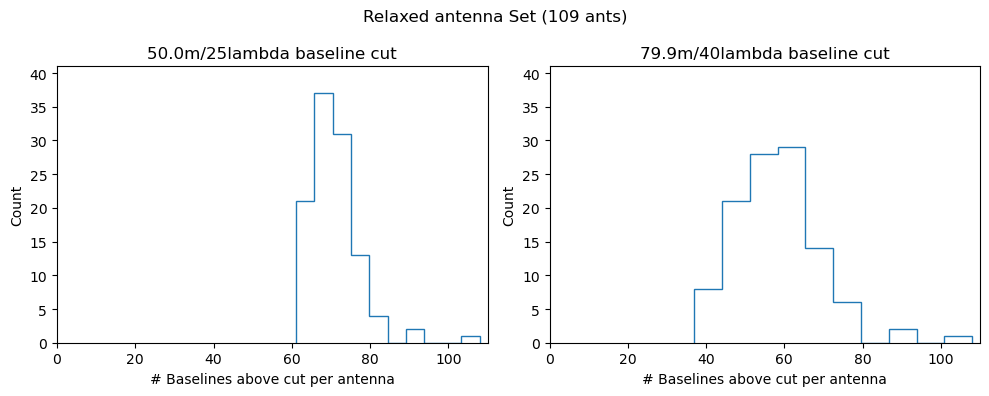

In [130]:
plotBlLengthHists_perAnt(uv,bl_cut=[25,40],freq=150,suptitle='Medium Restrictive Antenna Set (22 ants)')
plotBlLengthHists_perAnt(uvfull,bl_cut=[25,40],freq=150,suptitle='Relaxed antenna Set (109 ants)')